# Soil Organic Carbon Model

Maria Oros
JH Lab 2024

## Import ML packages

In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import joblib
import pandas as pd
import time

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

In [6]:
import seaborn as sns

## Data input

In [7]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
genral_path='/content/drive/Shareddrives/DS Projects/Jingyi Huang-Cyber Infrastructure/CyberInfraestructure/InputSoilData/'



data = pd.read_csv(genral_path+'final_conus_v2.csv')

### Pre procesing

In [120]:
target='soil_organic_carbon'
soil_armonized_complete=data[data[target].between(0,100)]
soil_armonized_complete=soil_armonized_complete[~soil_armonized_complete['clay_mean'].isna()]

grouped = soil_armonized_complete.groupby(['latitude', 'longitude', 'depth_cm'])

# Select the first row of each group (arbitrarily choosing the first)
reduced_data = grouped.first().reset_index()


print(reduced_data.columns)

Index(['latitude', 'longitude', 'depth_cm', 'Unnamed: 0', 'soil_id', 'year',
       'soil_organic_carbon', 'land_use', 'land_cover', 'land_cover_class',
       'land_use_class', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'label'],
      dtype='object')


In [15]:
reduced_data.shape

(37992, 26)

In [18]:
reduced_data.drop(['Unnamed: 0'],axis=1,inplace= True)

In [16]:
reduced_data[['soil_organic_carbon', 'land_use', 'land_cover', 'land_cover_class',
       'land_use_class', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean']].describe()

,soil_organic_carbon,land_use,land_cover,total_precipitation,min_temperature,mean_temperature,max_temperature,dem,slope,aspect,hillshade,bd_mean,clay_mean,om_mean,ph_mean,sand_mean,silt_mean
count,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000
mean,1.496149,3.117183,5.926827,1078.911728,5.324146,23.296360,17.972214,508.032610,4.369680,174.740901,180.133791,1.378652,21.017026,-0.135957,6.047998,31.987844,42.511539
std,3.579501,1.777600,4.458491,552.144559,3.963573,7.861087,4.067408,581.363783,5.799869,103.047888,15.858041,0.134064,11.893299,0.541414,1.020802,22.702238,17.642474
min,0.000020,1.000000,1.000000,26.470000,-12.104932,-8.067233,2.382658,-2.063870,0.000000,0.000000,62.000000,0.510000,0.500000,-4.965000,2.485503,0.838867,0.500000
25%,0.255099,1.000000,1.000000,775.000000,2.437178,18.429397,15.636130,210.603302,0.662710,86.196107,177.000000,1.326348,12.354945,-0.541625,5.216519,13.632780,29.598166
50%,0.697981,3.000000,10.000000,1051.470000,6.469945,25.146630,18.868685,301.894043,2.049632,174.036351,180.000000,1.388480,18.894739,-0.107041,5.876823,25.748042,42.750610
75%,1.572189,3.000000,10.000000,1269.910000,7.553562,27.874795,20.228767,460.408691,5.636532,262.918676,184.000000,1.447839,27.412397,0.233735,6.698348,46.800392,57.094539
max,67.788097,6.000000,14.000000,4887.200000,19.751342,48.934630,31.150219,3883.314453,46.889959,359.929312,255.000000,1.942642,74.155243,1.943514,9.534649,99.500000,93.468651


In [19]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37992 entries, 0 to 37991
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             37992 non-null  float64
 1   longitude            37992 non-null  float64
 2   depth_cm             37992 non-null  int64  
 3   soil_id              37992 non-null  object 
 4   year                 37992 non-null  int64  
 5   soil_organic_carbon  37992 non-null  float64
 6   land_use             37992 non-null  float64
 7   land_cover           37992 non-null  float64
 8   land_cover_class     37992 non-null  object 
 9   land_use_class       37992 non-null  object 
 10  total_precipitation  37992 non-null  float64
 11  min_temperature      37992 non-null  float64
 12  mean_temperature     37992 non-null  float64
 13  max_temperature      37992 non-null  float64
 14  dem                  37992 non-null  float64
 15  slope                37992 non-null 

In [20]:
reduced_data['land_use'] = reduced_data['land_use'].astype('category')
reduced_data['land_cover'] = reduced_data['land_cover'].astype('category')

<Axes: xlabel='year', ylabel='soil_organic_carbon'>

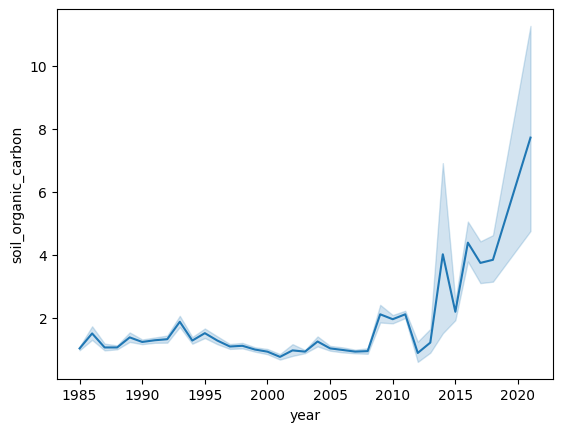

In [17]:
sns.lineplot(data=reduced_data, x="year", y="soil_organic_carbon"#, hue="version"
)

### Random Forest Regression

In [21]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37992 entries, 0 to 37991
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   latitude             37992 non-null  float64 
 1   longitude            37992 non-null  float64 
 2   depth_cm             37992 non-null  int64   
 3   soil_id              37992 non-null  object  
 4   year                 37992 non-null  int64   
 5   soil_organic_carbon  37992 non-null  float64 
 6   land_use             37992 non-null  category
 7   land_cover           37992 non-null  category
 8   land_cover_class     37992 non-null  object  
 9   land_use_class       37992 non-null  object  
 10  total_precipitation  37992 non-null  float64 
 11  min_temperature      37992 non-null  float64 
 12  mean_temperature     37992 non-null  float64 
 13  max_temperature      37992 non-null  float64 
 14  dem                  37992 non-null  float64 
 15  slope              

In [22]:
reduced_data.columns

Index(['latitude', 'longitude', 'depth_cm', 'soil_id', 'year',
       'soil_organic_carbon', 'land_use', 'land_cover', 'land_cover_class',
       'land_use_class', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'label'],
      dtype='object')

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

key_variables =list(sorted(['year',
                  'soil_organic_carbon',
                  #'depth_cm',
                  'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean'
       #,'land_use', 'land_cover'
                            ]))

soil_data = reduced_data
class_counts = reduced_data['soil_id'].value_counts()

# Filter classes with at least two instances
filtered_data = soil_data[soil_data['soil_id'].isin(class_counts[class_counts > 1].index)]
filtered_data=filtered_data[filtered_data['soil_organic_carbon'].between(0,100)]

### Data visualization

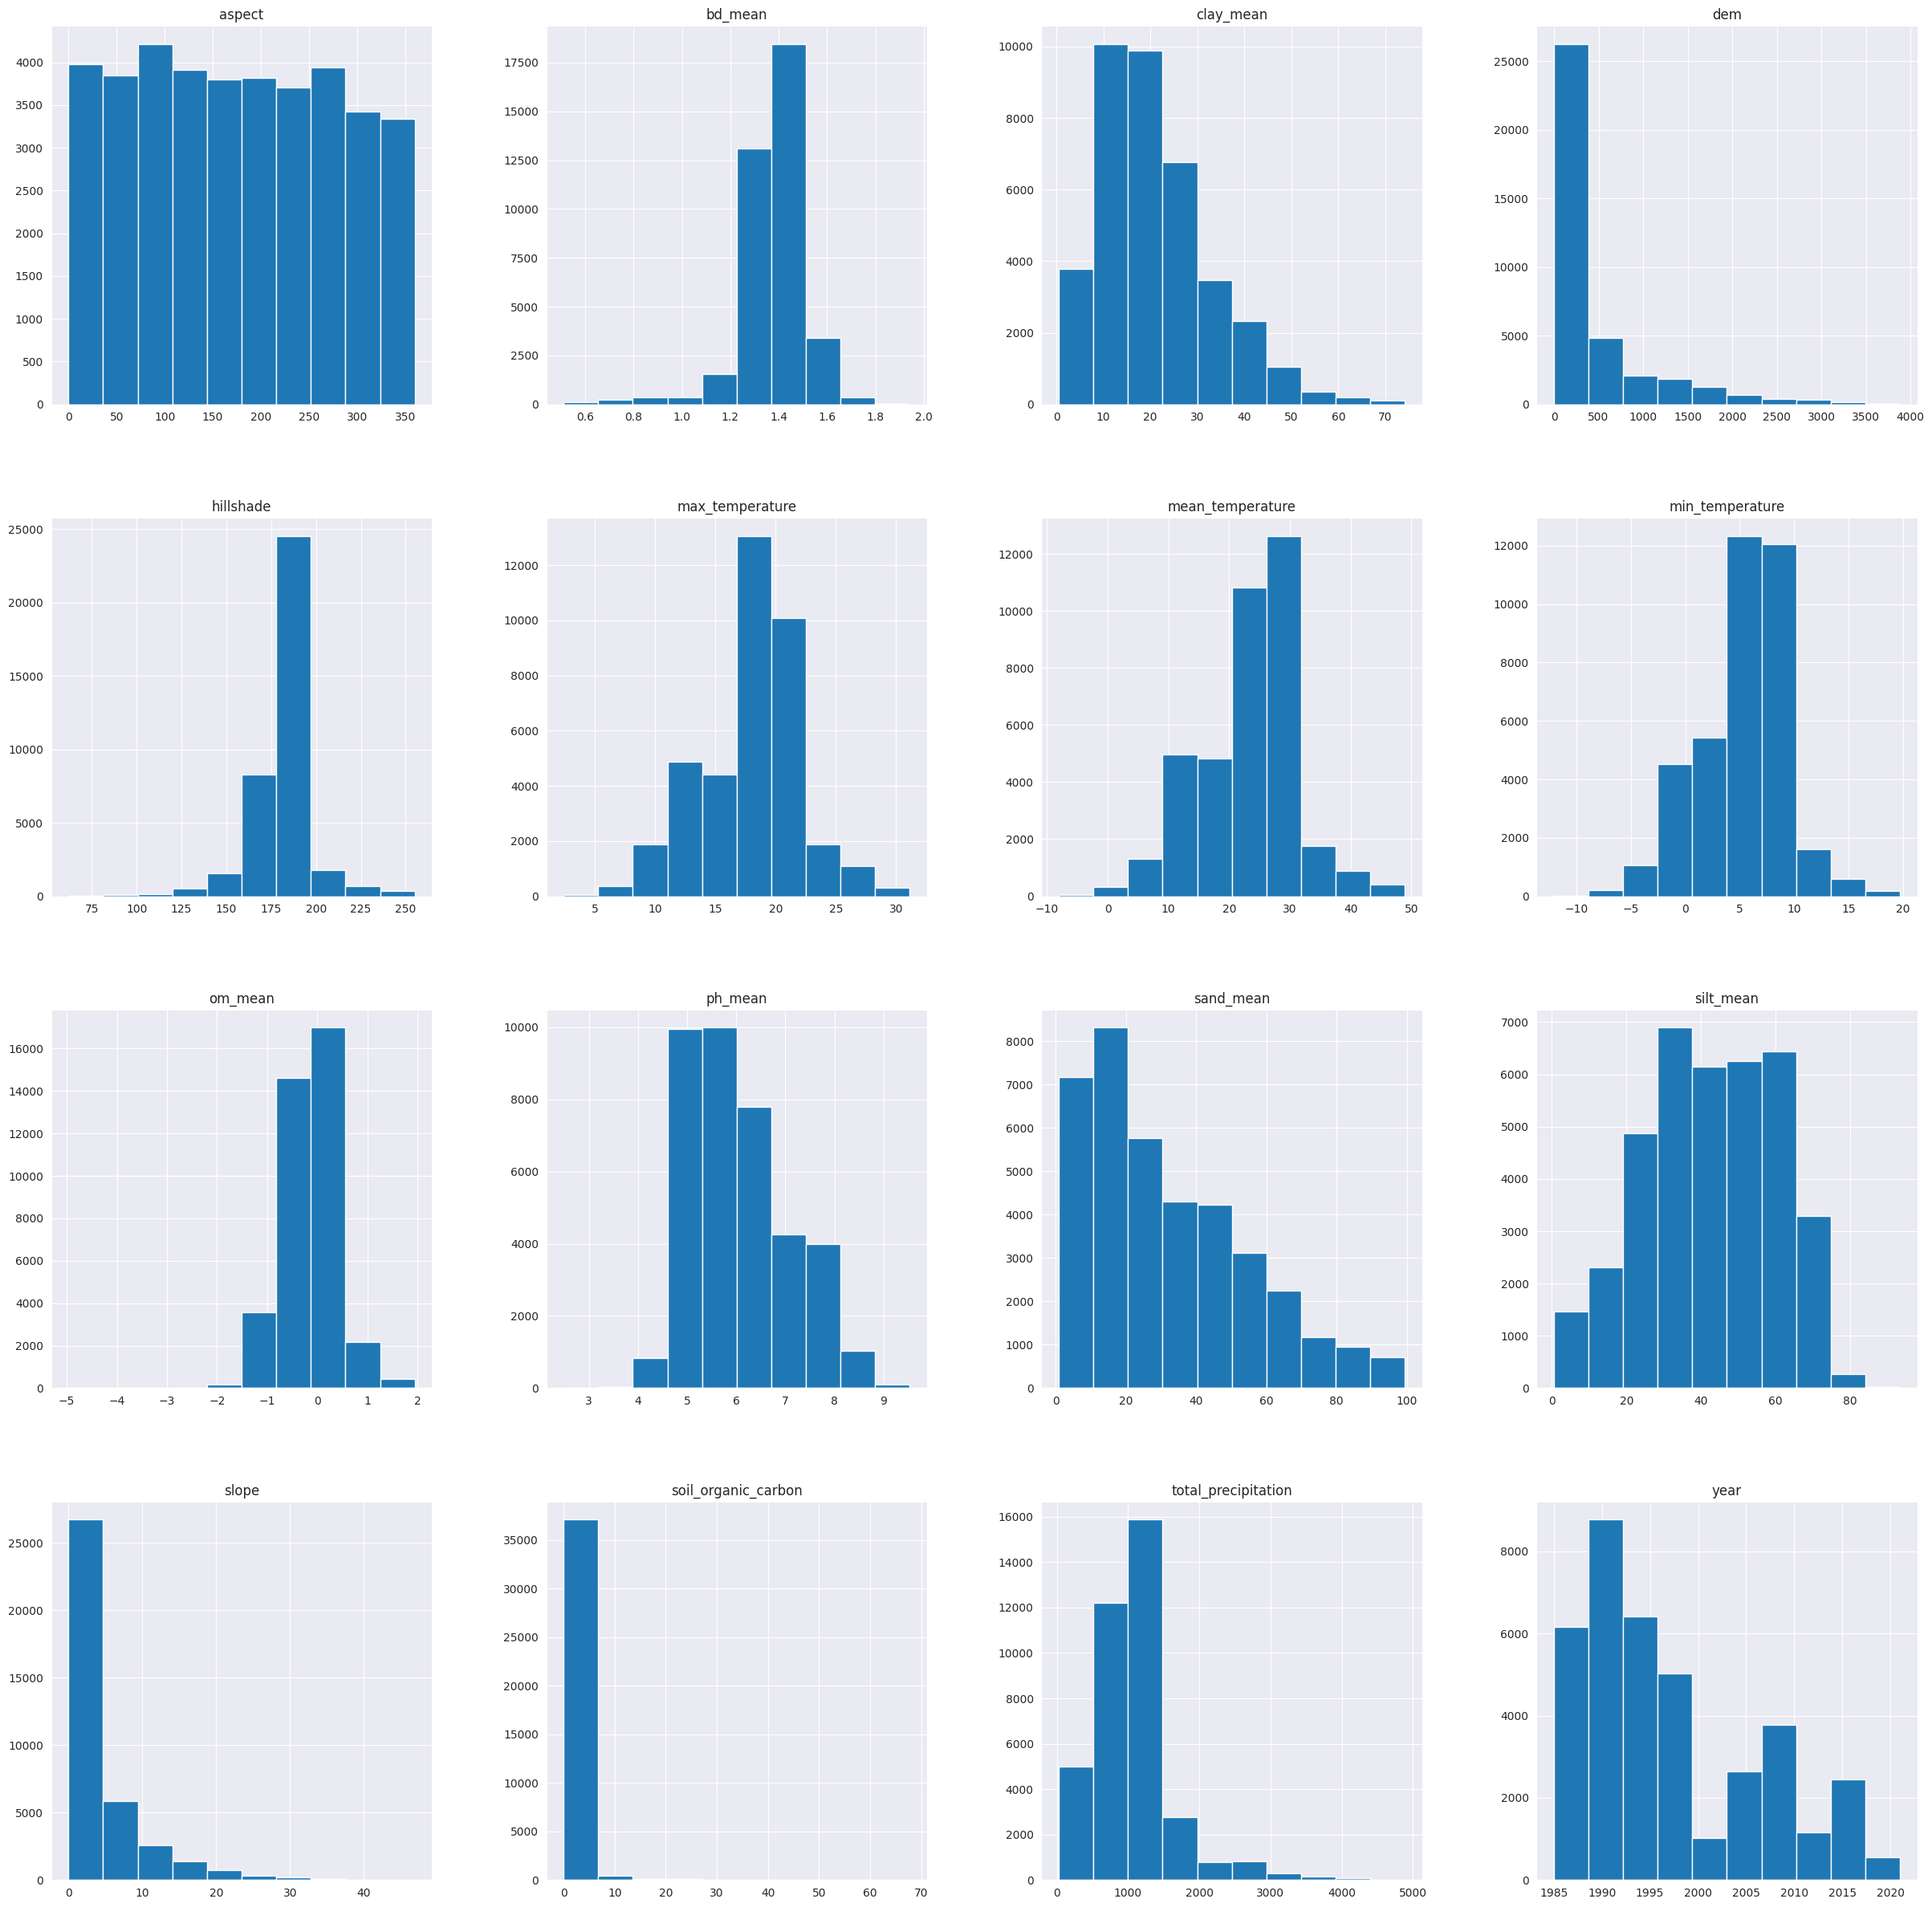

In [31]:

# Plot histograms for each variable
sns.set_style('darkgrid')
filtered_data[key_variables].hist(figsize=(30,30))
plt.show()

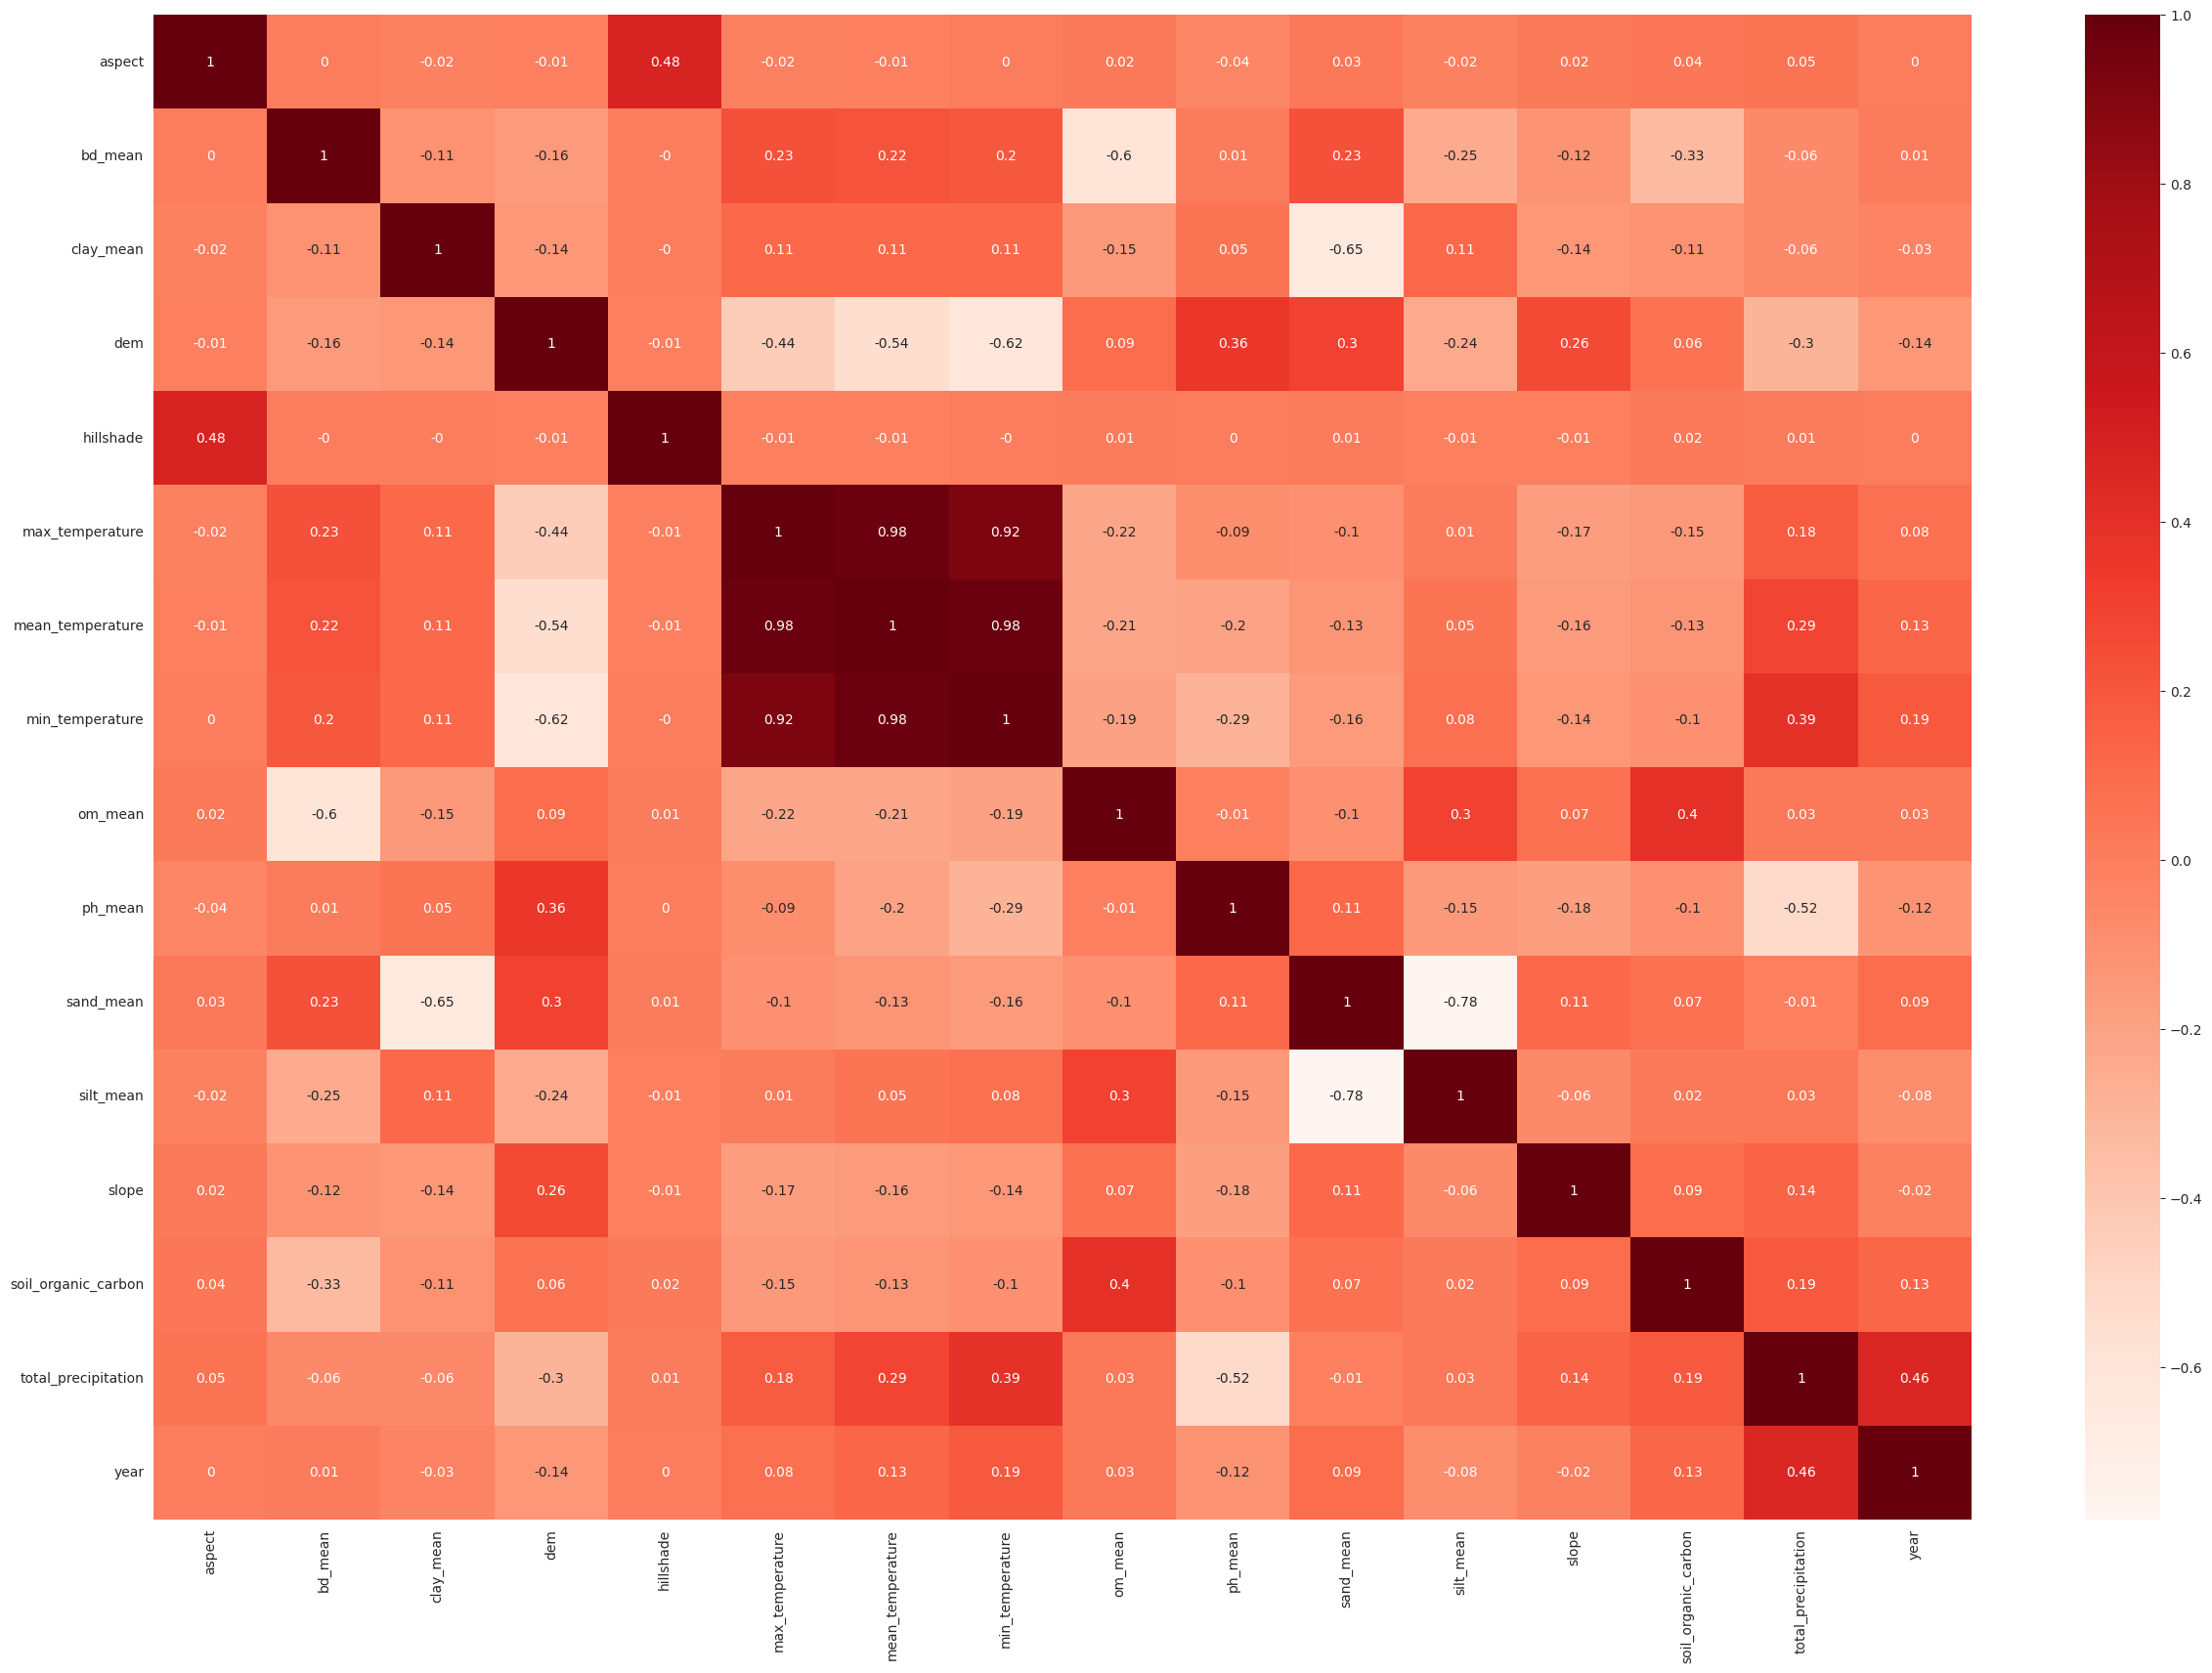

In [32]:
plt.figure(figsize=(30,20))
cor = filtered_data[key_variables].corr().round(2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [36]:

#Correlation with output variable
cor_target = abs(cor["soil_organic_carbon"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

,soil_organic_carbon
bd_mean,0.33
om_mean,0.40
soil_organic_carbon,1.00


## Model train and test split

In [37]:
class_counts = filtered_data['soil_id'].value_counts()

# Filter classes with at least two instances
filtered_data = filtered_data[filtered_data['soil_id'].isin(class_counts[class_counts > 1].index)]

filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37972 entries, 0 to 37991
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   latitude             37972 non-null  float64 
 1   longitude            37972 non-null  float64 
 2   depth_cm             37972 non-null  int64   
 3   soil_id              37972 non-null  object  
 4   year                 37972 non-null  int64   
 5   soil_organic_carbon  37972 non-null  float64 
 6   land_use             37972 non-null  category
 7   land_cover           37972 non-null  category
 8   land_cover_class     37972 non-null  object  
 9   land_use_class       37972 non-null  object  
 10  total_precipitation  37972 non-null  float64 
 11  min_temperature      37972 non-null  float64 
 12  mean_temperature     37972 non-null  float64 
 13  max_temperature      37972 non-null  float64 
 14  dem                  37972 non-null  float64 
 15  slope                379

In [43]:
filtered_data.columns

Index(['latitude', 'longitude', 'depth_cm', 'soil_id', 'year',
       'soil_organic_carbon', 'land_use', 'land_cover', 'land_cover_class',
       'land_use_class', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'label'],
      dtype='object')

In [45]:
#Split the data into predictor variables and target variable, following by breaking them into train and test sets.
df = filtered_data

print(len(df))

Y = df['soil_organic_carbon'].values
X = df[['depth_cm', 'land_use', 'land_cover',
        'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean']]
#.drop('soil_organic_carbon', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)

37972


## Modeling Approach

In [40]:
!pip install xgboost


In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb

from xgboost import XGBRegressor

In [102]:
# Define models to train
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('SVR', SVR()))
models.append(('XGBoost', xgb.XGBRegressor()))


In [63]:

# Define scoring metrics for regression
scoring = 'r2'

# Evaluate each model in turn
results = []
names = []

for name, model in models:
  if name=='XGBoost':

    # One-hot encoding
    X_train = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])

    model = XGBRegressor(enable_categorical=True)

  kfold = KFold(n_splits=10, shuffle=True, random_state=1)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)

  names.append(name)
  msg = "For %s Model: R2 is %f (Std R2 is %f)" % (name, -cv_results.mean(), cv_results.std())
  print(msg)

#above should be positive eg instead of -cv_results.mean() is cv_results.mean()

For Linear Regression Model: R2 is -0.236178 (Std R2 is 0.023060)
For Random Forest Model: R2 is -0.482262 (Std R2 is 0.090307)
For SVR Model: R2 is -0.052826 (Std R2 is 0.009855)


KeyError: "None of [Index(['land_use', 'land_cover'], dtype='object')] are in the [columns]"

In [48]:
X_train.columns

Index(['depth_cm', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'land_use_1.0', 'land_use_2.0', 'land_use_3.0',
       'land_use_4.0', 'land_use_5.0', 'land_use_6.0', 'land_cover_1.0',
       'land_cover_3.0', 'land_cover_4.0', 'land_cover_7.0', 'land_cover_8.0',
       'land_cover_9.0', 'land_cover_10.0', 'land_cover_12.0',
       'land_cover_14.0'],
      dtype='object')

In [65]:
Y = df['soil_organic_carbon'].values
X = df[['depth_cm', 'land_use', 'land_cover',
        'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean']]
#.drop('soil_organic_carbon', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)
X_train.columns

Index(['depth_cm', 'land_use', 'land_cover', 'total_precipitation',
       'min_temperature', 'mean_temperature', 'max_temperature', 'dem',
       'slope', 'aspect', 'hillshade', 'bd_mean', 'clay_mean', 'om_mean',
       'ph_mean', 'sand_mean', 'silt_mean'],
      dtype='object')

In [66]:
import pandas as pd

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])


from xgboost import XGBRegressor
model = XGBRegressor(enable_categorical=True)

In [67]:
import pandas as pd

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])


from xgboost import XGBRegressor
model = XGBRegressor(enable_categorical=True)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
results.append(cv_results)

#names.append(name)
msg = "For %s Model: Mean r2 is %f (Std r2 is %f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

names.append('XGBoostModel')

For XGBoost Model: Mean MSE is 0.520830 (Std MSE is 0.091833)


In [69]:
results

[array([0.2130361 , 0.25532838, 0.25319777, 0.24572737, 0.18596681,
        0.22225042, 0.26487188, 0.25761148, 0.23172237, 0.23206353]),
 array([0.39064339, 0.49623074, 0.52231609, 0.50184526, 0.28114174,
        0.49499196, 0.45820406, 0.64219608, 0.54685762, 0.48819473]),
 array([0.04789352, 0.05388786, 0.05984066, 0.0514464 , 0.05886423,
        0.04577619, 0.0580696 , 0.07097387, 0.04970012, 0.03180695]),
 array([0.52662161, 0.46887387, 0.55274156, 0.55786313, 0.29782029,
        0.46917138, 0.52904855, 0.67008295, 0.56985884, 0.56622117])]

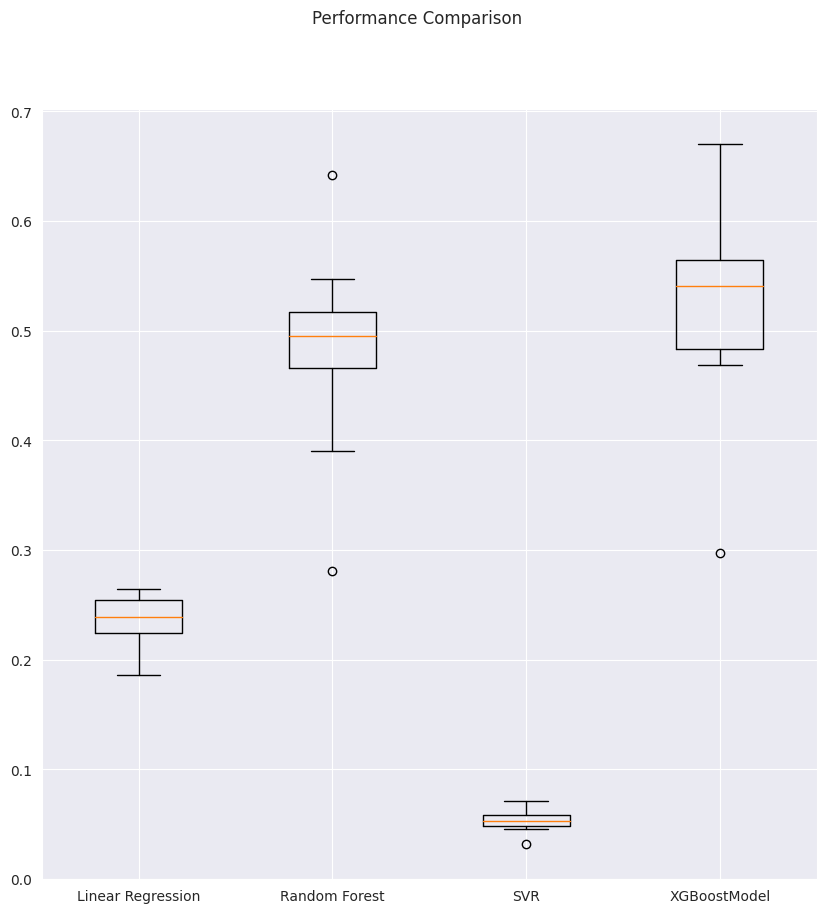

In [70]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


### Evaluating standarized data

In [73]:
# Standardize the dataset
import warnings
pipelines = []

pipelines.append(('Scaled Linear Regression', Pipeline([('Scaler', StandardScaler()),('Linear Regression', LinearRegression())])))
pipelines.append(('Scaled Random Forest', Pipeline([('Scaler', StandardScaler()),('Random Forest', RandomForestRegressor())])))
pipelines.append(('Scaled SVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))

results = []
names = []

kfold = KFold(n_splits= 10)
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print( "For %s Model: Mean Accuracy is %f (Std Accuracy is %f)" % (name, cv_results.mean(), cv_results.std()))

For Scaled Linear Regression Model: Mean Accuracy is 0.233921 (Std Accuracy is 0.013641)
For Scaled Random Forest Model: Mean Accuracy is 0.489855 (Std Accuracy is 0.068636)
For Scaled SVR Model: Mean Accuracy is 0.232187 (Std Accuracy is 0.022773)


In [75]:
results

[array([0.21260608, 0.22580179, 0.23766504, 0.21329075, 0.24277308,
        0.23281012, 0.23775844, 0.2317989 , 0.26018432, 0.24452108]),
 array([0.43114452, 0.47561156, 0.49063466, 0.4618209 , 0.51645299,
        0.38118087, 0.61441487, 0.41644954, 0.53732467, 0.5735109 ]),
 array([0.23560669, 0.22739497, 0.23643684, 0.21058894, 0.20451215,
        0.20874416, 0.26383066, 0.21465766, 0.24438636, 0.27570669])]

In [84]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

Y = df['soil_organic_carbon'].values
X = df[['depth_cm', 'land_use', 'land_cover',
        'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean']]
#.drop('soil_organic_carbon', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)
X_train = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])

print(X_train.columns)
# Define categorical columns
categorical_columns = ['land_use', 'land_cover']

# Define preprocessor with OneHotEncoder for categorical columns and StandardScaler for all columns
preprocessor = ColumnTransformer(
    transformers=[
        #('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), [col for col in X_train.columns if col not in categorical_columns])
    ]
)



# Create a pipeline with preprocessing and the XGBRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(enable_categorical=True))
])

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring='r2')


Index(['depth_cm', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'land_use_1.0', 'land_use_2.0', 'land_use_3.0',
       'land_use_4.0', 'land_use_5.0', 'land_use_6.0', 'land_cover_1.0',
       'land_cover_3.0', 'land_cover_4.0', 'land_cover_7.0', 'land_cover_8.0',
       'land_cover_9.0', 'land_cover_10.0', 'land_cover_12.0',
       'land_cover_14.0'],
      dtype='object')


In [86]:
cv_results

array([0.52448521, 0.46887459, 0.53681428, 0.55784222, 0.29782029,
       0.47348682, 0.53862996, 0.68307556, 0.5698587 , 0.56622264])

In [88]:
# Cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring='r2')
results.append(cv_results)
name = "XGBoost"
names.append(name)

# Print the results

msg = "For %s Model: Mean r2 is %f (Std r2 is %f)" % (name, cv_results.mean(), cv_results.std())
print(msg)


For XGBoost Model: Mean MSE is 0.521711 (Std MSE is 0.093493)


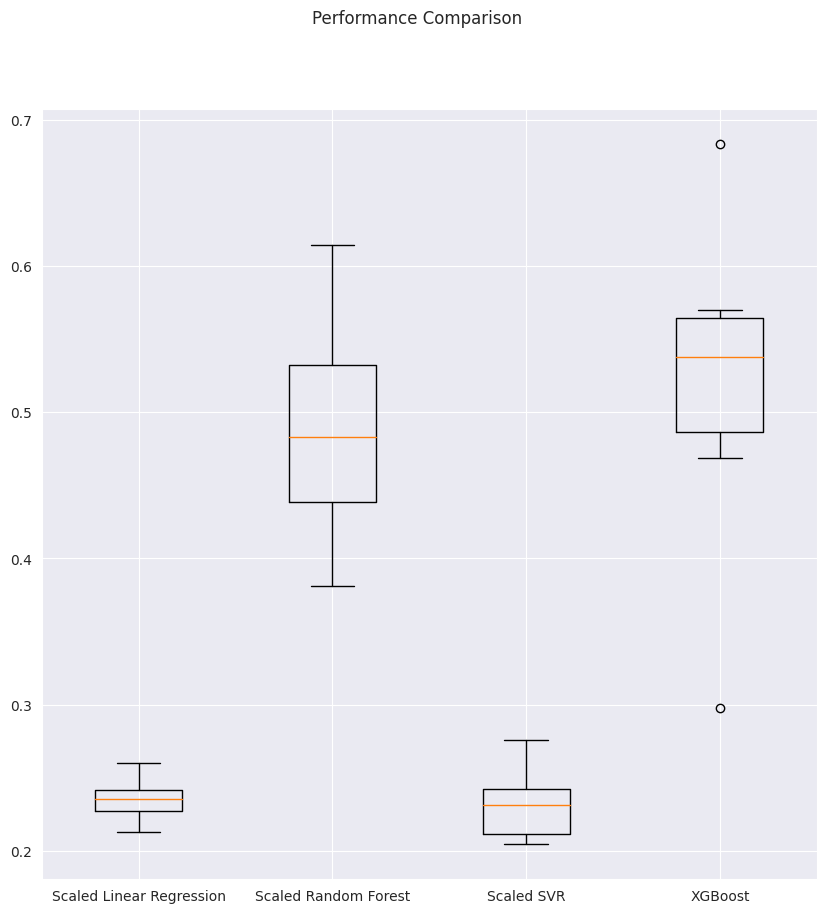

In [99]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


### Validation dataset

In [105]:
#
models=[('Linear Regression', LinearRegression()),
 ('Random Forest', RandomForestRegressor()),
 ('SVR', SVR()),
 #('XGBoost',XGBRegressor(enable_categorical=True))
 ]

In [ ]:

#predictions_cali = model.predict(X_train_scaled)
#print("R-squared calibration:", r2_score(Y_train, predictions_cali))

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define models
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('SVR', SVR())
    # ('XGBoost', XGBRegressor(enable_categorical=True)) # Uncomment if you want to use XGBoost
]

df = filtered_data

# Prepare the data
Y = df['soil_organic_carbon'].values
X = df[['depth_cm', 'land_use', 'land_cover', 'total_precipitation', 'min_temperature',
        'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
        'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
        'silt_mean']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=21)

# Iterate over models and evaluate
for name, model in models:
    try:
        # Apply scaling
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        predictions = model.predict(X_test_scaled)

        # Print the results
        print("\nModel:", name)
        print("Mean Squared Error:", mean_squared_error(Y_test, predictions))
        print("R-squared:", r2_score(Y_test, predictions))

        predictions_cali = model.predict(X_train_scaled)
        print("R-squared calibration:", r2_score(Y_train, predictions_cali))

    except Exception as e:
        print("Exception encountered with model", name, ":", e)



Model: Linear Regression
Mean Squared Error: 10.686309092016877
R-squared: 0.221979176758614
R-squared calibration: 0.23502099474488813

Model: Random Forest
Mean Squared Error: 6.724026359016811
R-squared: 0.5104546875546452
R-squared calibration: 0.9302601117689605

Model: SVR
Mean Squared Error: 10.590593394778496
R-squared: 0.22894779472776472
R-squared calibration: 0.2565878564351135


In [110]:
Y = df['soil_organic_carbon'].values
X = df[['depth_cm', 'land_use', 'land_cover', 'total_precipitation', 'min_temperature',
        'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
        'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
        'silt_mean']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=21)


X_train = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])
X_test = pd.get_dummies(X_test, columns=['land_use', 'land_cover'])

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model=XGBRegressor(enable_categorical=True)
# Train the model
model.fit(X_train_scaled, Y_train)

# Make predictions
predictions = model.predict(X_test_scaled)

# Print the results
print("\nModel:", name)
print("Mean Squared Error:", mean_squared_error(Y_test, predictions))
print("R-squared:", r2_score(Y_test, predictions))

predictions_cali = model.predict(X_train_scaled)
print("R-squared calibration:", r2_score(Y_train, predictions_cali))


Model: SVR
Mean Squared Error: 5.886467177663006
R-squared: 0.5714335042984983


In [116]:
# Save the model to a file
joblib.dump(model, '/content/drive/Shareddrives/DS Projects/Jingyi Huang-Cyber Infrastructure/CyberInfraestructure/xgb_model.joblib')


['/content/drive/Shareddrives/DS Projects/Jingyi Huang-Cyber Infrastructure/CyberInfraestructure/xgb_model.joblib']